## Lesson 3: Collaborative-based recommender systems: Factorization

https://www.kaggle.com/prashant111/recommender-systems-in-python

https://towardsdatascience.com/recsys-series-part-4-the-7-variants-of-matrix-factorization-for-collaborative-filtering-368754e4fab5

https://heartbeat.fritz.ai/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

In [1]:
def evaluate(predict_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([predict_f(u,i) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))


## Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

In [2]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../data/ml-1m/users.dat', sep='::', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep='::', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('../data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


print("Full DB has "+ str(data.shape[0]) +" ratings")
print("Full DB has ", data.user_id.nunique()," users")
print("Full DB has ", data.movie_id.nunique(), " movies")
data.head()




## DIVIDE THE DATA INTO TRAINING AND TEST SET
data['for_testing'] = False
grouped = data.groupby('user_id', group_keys=False).apply(assign_to_set)
data_train = data[grouped.for_testing == False]
data_test = data[grouped.for_testing == True]


print("Training data_set has "+ str(data_train.shape[0]) +" ratings")
print("Test data set has "+ str(data_test.shape[0]) +" ratings")

Autosaving every 150 seconds


<ipython-input-2-5608d553b072>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('../data/ml-1m/users.dat', sep='::', names=u_cols)
<ipython-input-2-5608d553b072>:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep='::', names=r_cols)
<ipython-input-2-5608d553b072>:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('../d

Full DB has 1000209 ratings
Full DB has  6040  users
Full DB has  3706  movies
Training data_set has 797758 ratings
Test data set has 202451 ratings


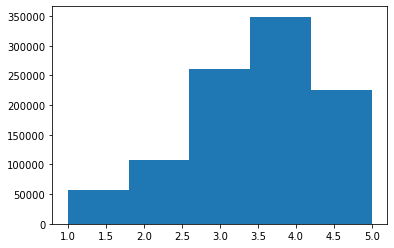

In [3]:
plt.hist(data.rating,bins=5)
plt.show()

In [4]:
data.groupby(by='rating').count()

,user_id,title,movie_id,release_date,sex,age,for_testing
rating,,,,,,,
1,56174,56174,56174,56174,56174,56174,56174
2,107557,107557,107557,107557,107557,107557,107557
3,261197,261197,261197,261197,261197,261197,261197
4,348971,348971,348971,348971,348971,348971,348971
5,226310,226310,226310,226310,226310,226310,226310


### Factorization Matrix as Dimensionality Reduction

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

class SVD_CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self,DataFrame, num_components=10):
        """ Constructor """
        self.df=DataFrame
        ##self.sim = pd.DataFrame(np.sum([0]),columns=data_train.user_id.unique(), index=data_train.user_id.unique())
        self.num_components=num_components
        
    def fit(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allUsers=set(self.df['user_id'])
        
        svd = TruncatedSVD(n_components=self.num_components)
        
        urm = pd.pivot_table(self.df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating',fill_value=0)
        
        user_index = np.arange(len(urm.index))
        self.users = dict(zip(user_index,urm.index ))
        self.users_id2index = dict(zip(urm.index,user_index)) 
        
        movie_index = np.arange(len(urm.columns))
        self.movies_id2index= dict(zip(urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,urm.columns))
        
        X= np.float32(urm.values)
        
        
        #Lets continue.....
        matrix = svd.fit_transform(X)
        print(matrix.shape)
        self.sim = np.corrcoef(matrix)
    
    def predict(self, user_id, movie_id):
        movie_users = self.df[self.df['movie_id'] ==movie_id]
        #movie_users = movie_users.set_index('user_id')
                
        allUsers = [ self.users_id2index[user_index] for user_index in movie_users.user_id if user_index in self.users_id2index] 
        a = movie_users.rating.values
        b = self.sim[self.users_id2index[user_id]][allUsers] 
        rating_num = np.sum(a*b)
        rating_den = np.sum(b)
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return rating_num/rating_den


In [13]:
reco = SVD_CollaborativeFiltering(data_train,num_components=10)
reco.fit()
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

(6040, 10)
RMSE for Collaborative Recomender: 1.0380034016565982


### FACTORIZATION MODEL SVD

![alt Amazon](https://miro.medium.com/max/4800/1*b4M7o7W8bfRRxdMxtFoVBQ.png)

In [14]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
from scipy.linalg import sqrtm

class RecSys_SVD:
    """ Collaborative filtering using SVD. """
    
    def __init__(self,DataFrame, num_components=10,method = 'svd'):
        """ Constructor """
        self.df=DataFrame
        ##self.sim = pd.DataFrame(np.sum([0]),columns=data_train.user_id.unique(), index=data_train.user_id.unique())
        self.num_components=num_components
        self.method = method
        
    def fit(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allUsers=set(self.df['user_id'])
        
        if(self.method =='TruncatedSVD'):
            svd = TruncatedSVD(n_components=self.num_components)
            train = pd.pivot_table(self.df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating',fill_value=0)
            self.Y_hat = svd.fit_transform(np.float32(train.values))
        elif(self.method == 'svd'):
            train = pd.pivot_table(self.df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
            train_matrix = np.array(train)
            # we mask those nan value to fill with the mean 
            mask = np.isnan(train_matrix)
            masked_arr = np.ma.masked_array(train_matrix, mask)
            item_means = np.mean(masked_arr, axis=0)

            # nan entries will replaced by the average rating for each item
            train_matrix = masked_arr.filled(item_means)
            x = np.tile(item_means, (train_matrix.shape[0],1))         
            
            # we remove the per item average from all entries.
            # the above mentioned nan entries will be essentially zero now
            train_matrix = train_matrix - x
            self.train_matrix = train_matrix
            U, s, V = np.linalg.svd(train_matrix, full_matrices=False)
            s = np.diag(s)
            
            # reconstruct rating matix
            
            s=s[0:self.num_components,0:self.num_components]
            U=U[:,0:self.num_components]
            V=V[0:self.num_components,:]
            s_root=sqrtm(s)

            Usk=np.dot(U,s_root)
            skV=np.dot(s_root,V)
            Y_hat = np.dot(Usk, skV)
            self.Y_hat = Y_hat + x

        else:
            print("method not implemented")
        
        user_index = np.arange(len(train.index))
        self.users = dict(zip(user_index,train.index ))
        self.users_id2index = dict(zip(train.index,user_index)) 
        
        movie_index = np.arange(len(train.columns))
        self.movies_id2index= dict(zip(train.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,train.columns))
                


    def predict(self, user_id, movie_id):
        if movie_id in self.movies_id2index:
            return self.Y_hat[self.users_id2index[user_id],self.movies_id2index[movie_id]]
        else: 
            return 3


In [15]:
reco = RecSys_SVD(data_train,num_components=30)
reco.fit()
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

RMSE for Collaborative Recomender: 1.0015868246693787


## The Vanilla Matrix Factorization Model

A straightforward matrix factorization model maps both users and items to a joint latent factor space of dimensionality D. User-item interaction are modeled as inner products in that space
$$R = UV$$

Each item j is associated with a vector $v_j$ from $V$, and each user $i$ is associated with a vecor $u_i$ from $U$.
The resulting dot product $u_i\cdot v_j$ captures the interaction between the user $i$ and item $j$:
$$ \hat{r} = u_i\cdot v_j$$

The goal of the matrix factorization consist on finding the mapping of each item and user to factors $u_i$ and $v_j$. To do so, the minimization the of squarred error function is performed:
$$ \sum(R_{ui} - u_i\cdot v_j)^2$$

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

class RecSys_MF:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self,DataFrame, num_components=10, learning_rate =0.001,
                 lmbda=0.1, 
                 verbose =True):
        
        """ Constructor """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        self.num_components = num_components
        
        self.df = DataFrame
        
        
        urm = pd.pivot_table(self.df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating',fill_value=0)
        self.n_users, self.n_items = urm.shape
        self.ratings = np.float32(urm.values)
        
        user_index = np.arange(len(urm.index))
        self.users = dict(zip(user_index,urm.index ))
        self.users_id2index = dict(zip(urm.index,user_index)) 
        
        
        movie_index = np.arange(len(urm.columns))
        self.movies = dict(zip(movie_index,urm.columns ))   
        self.movies_id2index= dict(zip(urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,urm.columns))
        self.movie_id2title = dict(self.df.groupby(by=['movie_id','title']).count().index)
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
    
    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - \
                                     self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - \
                                     self.lmbda * self.item_vecs[i,:])
                
                
    def fit(self,n_epochs = 10):
        """ Train the model. """
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = 3.*np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = 3.*np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))

        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_mse.append(evaluate(self.predict,data_train,data_train))
            self.test_mse.append(evaluate(self.predict,data_train,data_test))
            
            
            print('\tTrain mse: %s' % self.train_mse[-1])
            print('\tTest mse: %s' % self.test_mse[-1])
            
            
        
        if(self.verbose):
            plt.plot(self.train_mse,'--o',label="train_error")
            plt.plot(self.test_mse,'--o',label="test_error")
            plt.legend()
            plt.show()
            
            ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
            estimated = np.array([self.predict(u,i) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
            real = data_test.rating.values
            plt.plot(estimated,real,'.',alpha=0.1)
            plt.show()
    
    def predict(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T)
        else:
            prediction = 3 # this is a new movie
        if(prediction>5):
            return 5
        elif(prediction<1):
            return 1
        return prediction
    

Epoch: 0
	Train mse: 1.310042838444633
	Test mse: 1.3269173222438273
Epoch: 1
	Train mse: 1.1300935252665854
	Test mse: 1.143975232484266
Epoch: 2
	Train mse: 1.1049274794290267
	Test mse: 1.1167400035534227
Epoch: 3
	Train mse: 1.0941892018883779
	Test mse: 1.1050392916621414
Epoch: 4
	Train mse: 1.0926548888703702
	Test mse: 1.1027715066651238
Epoch: 5
	Train mse: 1.0905086916258453
	Test mse: 1.1007007798836808
Epoch: 6
	Train mse: 1.0901575704254487
	Test mse: 1.1003483099103442
Epoch: 7
	Train mse: 1.0882435967102695
	Test mse: 1.0984563996839067
Epoch: 8
	Train mse: 1.0899361502278713
	Test mse: 1.1002715843114323
Epoch: 9
	Train mse: 1.091363174066147
	Test mse: 1.1014364776769536
Epoch: 10
	Train mse: 1.0899283617760749
	Test mse: 1.0998108239674056
Epoch: 11
	Train mse: 1.0884663291274799
	Test mse: 1.098663986961516
Epoch: 12
	Train mse: 1.0878876719414872
	Test mse: 1.0982343108648545
Epoch: 13
	Train mse: 1.0887696253851922
	Test mse: 1.0989358826636264
Epoch: 14
	Train mse

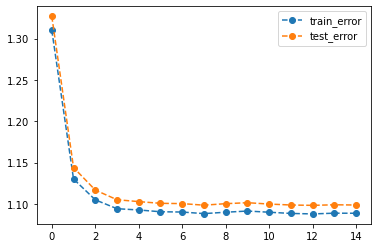

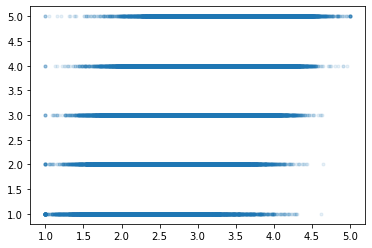

RMSE for Collaborative Recomender: 1.0986524638655664


In [15]:
reco = SVD_CollaborativeFiltering(data_train,num_components=5,learning_rate=0.01,lmbda=0.5)
reco.fit(n_epochs = 15)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

Epoch: 0
	Train mse: 1.1793837818218182
	Test mse: 1.2024172620494142
Epoch: 1
	Train mse: 1.0300435804887853
	Test mse: 1.0503022998330052
Epoch: 2
	Train mse: 1.0062275708046684
	Test mse: 1.024365789391161
Epoch: 3
	Train mse: 0.9997142287974103
	Test mse: 1.017227079554313
Epoch: 4
	Train mse: 0.9967513653645441
	Test mse: 1.014362919066647
Epoch: 5
	Train mse: 0.9934908208726374
	Test mse: 1.0108343335588286
Epoch: 6
	Train mse: 0.9915816661070053
	Test mse: 1.0084018472729732
Epoch: 7
	Train mse: 0.989411245280119
	Test mse: 1.0065228296822797
Epoch: 8
	Train mse: 0.9860264241865485
	Test mse: 1.0040461438591086
Epoch: 9
	Train mse: 0.981864071163888
	Test mse: 0.9999697769933519
Epoch: 10
	Train mse: 0.9797553021518595
	Test mse: 0.998059610605291
Epoch: 11
	Train mse: 0.9770872369503233
	Test mse: 0.9961071744626714
Epoch: 12
	Train mse: 0.9746622311546532
	Test mse: 0.9936720610418135
Epoch: 13
	Train mse: 0.9722390147737763
	Test mse: 0.9918487316949486
Epoch: 14
	Train mse: 

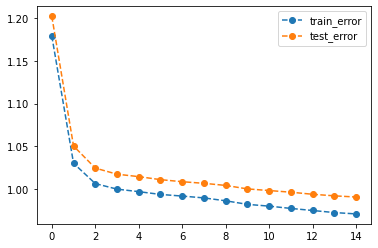

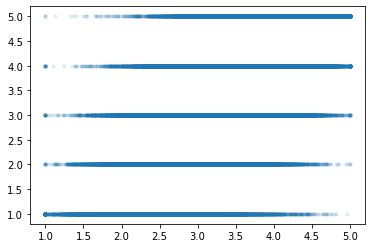

RMSE for Collaborative Recomender: 0.9904458516603255


In [16]:
reco = RecSys_MF(data_train,num_components=5,learning_rate=0.01)
reco.fit(n_epochs = 15)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))


Epoch: 0
	Train mse: 1.0604968262056493
	Test mse: 1.0792653277451376
Epoch: 1
	Train mse: 1.0147231289269
	Test mse: 1.0309371052858372
Epoch: 2
	Train mse: 1.0068526911213218
	Test mse: 1.0224674294125844
Epoch: 3
	Train mse: 1.0012034792761029
	Test mse: 1.0176554587471005
Epoch: 4
	Train mse: 0.9963738032339874
	Test mse: 1.0125751859585403
Epoch: 5
	Train mse: 0.991254984362413
	Test mse: 1.0079916081478197
Epoch: 6
	Train mse: 0.987899729113836
	Test mse: 1.0054179302711348
Epoch: 7
	Train mse: 0.9847120170152752
	Test mse: 1.002743147351024
Epoch: 8
	Train mse: 0.9825051550859403
	Test mse: 1.0001269177571632
Epoch: 9
	Train mse: 0.9801954836665856
	Test mse: 0.9977419908136745
Epoch: 10
	Train mse: 0.9799325836669912
	Test mse: 0.9987464482705074
Epoch: 11
	Train mse: 0.9795880973433926
	Test mse: 0.9980491124387204
Epoch: 12
	Train mse: 0.9742430898332499
	Test mse: 0.993361463525915
Epoch: 13
	Train mse: 0.9752551031098831
	Test mse: 0.9945791933183421
Epoch: 14
	Train mse: 0

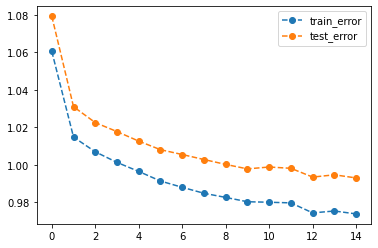

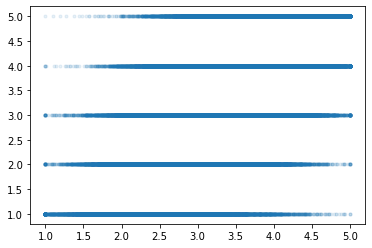

RMSE for Collaborative Recomender: 0.9929070733798698


In [17]:
reco = RecSys_MF(data_train,num_components=3,learning_rate=0.02)
reco.fit(n_epochs = 15)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

In [18]:
print(set(reco.df[reco.df.title=='Lion King, The (1994)'].movie_id))

{364}


In [19]:
movie_id = 1 #'Toy Story (1995)'
movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

NameError: name 'euclidean_distances' is not defined

In [ ]:
reco = RecSys_MF(data_train,num_components=100,
                                  item_fact_reg=0.1,user_fact_reg=0.1)
reco.fit(n_epochs = 20)
reco.predict(user_id=2,movie_id=1)

In [ ]:
reco = RecSys_MF(data_train,num_components=100,
                                  item_fact_reg=0.5,user_fact_reg=0.5)
reco.fit(n_epochs = 20)
reco.predict(user_id=2,movie_id=1)

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

class RecSys_MF_biases:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self,DataFrame, num_components=10, learning_rate =0.001,
                 lmbda=0.1, 
                 verbose =True):
        
        """ Constructor """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        self.num_components = num_components
        
        self.df = DataFrame
        
        
        urm = pd.pivot_table(self.df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating',fill_value=0)
        self.n_users, self.n_items = urm.shape
        self.ratings = np.float32(urm.values)
        
        user_index = np.arange(len(urm.index))
        self.users = dict(zip(user_index,urm.index ))
        self.users_id2index = dict(zip(urm.index,user_index)) 
        
        
        movie_index = np.arange(len(urm.columns))
        self.movies = dict(zip(movie_index,urm.columns ))   
        self.movies_id2index= dict(zip(urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,urm.columns))
        self.movie_id2title = dict(self.df.groupby(by=['movie_id','title']).count().index)
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
      
            
            
    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - self.lmbda * self.item_vecs[i,:])
            
            self.bias_item[i] += self.learning_rate * (error - self.lmbda * self.bias_item[i]) 
            self.bias_user[u] += self.learning_rate * (error - self.lmbda * self.bias_user[u]) 
            
            #self.bias += self.learning_rate * (-error ) 
                
    def fit(self,n_epochs = 10):
        """ Train the model. """
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        #self.bias = -3
        self.bias_item = np.random.normal(scale=1/self.n_items,size=(self.n_items))
        self.bias_user = np.random.normal(scale=1/self.n_users,size=(self.n_users))
        
        
        for epoch in range(n_epochs):
    
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(reco.predict,data_train,data_train))
            self.test_rmse.append(evaluate(reco.predict,data_train,data_test))
            
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
            
            
        
        if(self.verbose):
            plt.plot(self.train_rmse,'--o',label="train_error")
            plt.plot(self.test_rmse,'--o',label="test_error")
            plt.legend()
            plt.show()
            
            ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
            estimated = np.array([reco.predict(u,i) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
            real = data_test.rating.values
            plt.plot(estimated,real,'.',alpha=0.1)
            plt.show()
    
    def predict(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  3 + self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T) + self.bias_item[item_index] + self.bias_user[user_index]
        else:
            prediction = 3 # this is a new movie
        '''if(prediction>5):
            return 5
        elif(prediction<1):
            return 1'''
        return prediction
    

Epoch: 0
	Train rmse: 0.9899964985414893
	Test rmse: 0.9996767800605498
Epoch: 1
	Train rmse: 0.9859144031368503
	Test rmse: 0.9967522892519943
Epoch: 2
	Train rmse: 0.9762877979982768
	Test rmse: 0.9902696685460405
Epoch: 3
	Train rmse: 0.9570750808505184
	Test rmse: 0.9783774559326134
Epoch: 4
	Train rmse: 0.9321018630455181
	Test rmse: 0.9669593050083682
Epoch: 5
	Train rmse: 0.903218083030246
	Test rmse: 0.958578743339581
Epoch: 6
	Train rmse: 0.8715662632022589
	Test rmse: 0.9536362367763528
Epoch: 7
	Train rmse: 0.8396342492667722
	Test rmse: 0.9533111122281371
Epoch: 8
	Train rmse: 0.8095136484774316
	Test rmse: 0.9554281679282774
Epoch: 9
	Train rmse: 0.7831487871243161
	Test rmse: 0.9595865166048172
Epoch: 10
	Train rmse: 0.7612933636810664
	Test rmse: 0.9645825395740132
Epoch: 11
	Train rmse: 0.7432375693305926
	Test rmse: 0.9697252439492675
Epoch: 12
	Train rmse: 0.7291734508198955
	Test rmse: 0.9746423615105173
Epoch: 13
	Train rmse: 0.7177876301155005
	Test rmse: 0.9794844

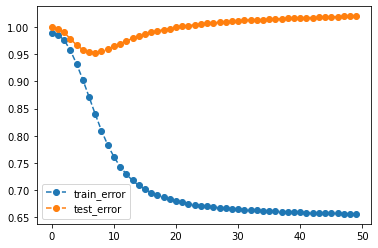

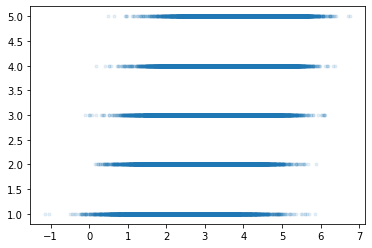

In [21]:
reco = RecSys_MF_biases(data_train,num_components=100,learning_rate=0.02,lmbda=0.02)
reco.fit(n_epochs = 50)

Epoch: 0
	Train rmse: 0.992943425608282
	Test rmse: 1.001790686002648
Epoch: 1
	Train rmse: 0.9892504726975943
	Test rmse: 0.9992153702462262
Epoch: 2
	Train rmse: 0.9883368572485848
	Test rmse: 0.9987145312142156
Epoch: 3
	Train rmse: 0.9871764920293519
	Test rmse: 0.9975320664756369
Epoch: 4
	Train rmse: 0.9855033786911588
	Test rmse: 0.996278091402162
Epoch: 5
	Train rmse: 0.9810549033518476
	Test rmse: 0.9929312790190957
Epoch: 6
	Train rmse: 0.9751984610380745
	Test rmse: 0.9876042836551296
Epoch: 7
	Train rmse: 0.9719417902474901
	Test rmse: 0.9854951005266427
Epoch: 8
	Train rmse: 0.9684723740324868
	Test rmse: 0.9832842859587272
Epoch: 9
	Train rmse: 0.9659303368623777
	Test rmse: 0.9814631230981836
Epoch: 10
	Train rmse: 0.963181682328815
	Test rmse: 0.9795674337331529
Epoch: 11
	Train rmse: 0.9596079171969386
	Test rmse: 0.9772070844813223
Epoch: 12
	Train rmse: 0.9569049232643058
	Test rmse: 0.9751011280593755
Epoch: 13
	Train rmse: 0.9543449556973864
	Test rmse: 0.973870711

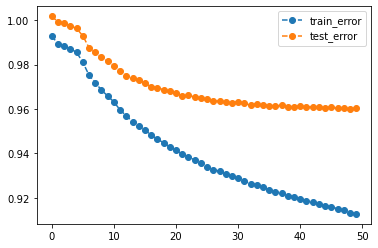

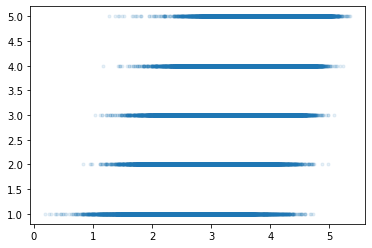

In [27]:
reco = RecSys_MF_biases(data_train,num_components=100,learning_rate=0.02,lmbda=0.1)
reco.fit(n_epochs = 50)

In [23]:
np.argsort(reco.bias_item)

array([1212, 1220, 1372, ..., 2007, 2687,   51])

In [24]:
movie_id = 1 #'Toy Story (1995)'
movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

NameError: name 'euclidean_distances' is not defined

In [ ]:
i = 645
print(reco.bias_item[i],movie_id2title[reco.movies_index2id[i]])
print(np.mean(reco.df[reco.df.movie_id==reco.movies_index2id[i]].rating))

In [ ]:
np.mean(reco.df[reco.df.movie_id==reco.movies_index2id[i]].rating)